In [2]:
import numpy as np
from sklearn.datasets import load_iris
from bnn import bayesianize
from Model_iris import classification
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.distributions as dist
from torch.utils.data import random_split, DataLoader, TensorDataset
%matplotlib inline

In [146]:
#Hyperparameter are based on table 5 of the paper
features, labels = load_iris(return_X_y=True)
features, labels = torch.from_numpy(features).float(), torch.from_numpy(labels).long()
data = TensorDataset(features, labels)    # Create a torch.utils.data.TensorDataset object for further data manipulation
train_set, test_set = random_split(
    data, [100, 50])
train_loader = DataLoader(train_set, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_set, batch_size = 16)
torch.manual_seed(0)

In [147]:
#layer_size = number of hidden layers except the first and last layer
model_1_ffg = classification(layer_size = 2, activation=False)
model_2_ffg = classification(layer_size = 3, activation=False)
model_3_ffg = classification(layer_size = 4, activation=False)
model_4_ffg = classification(layer_size = 5, activation=False)
model_1_fcg = classification(layer_size = 2, activation=False)
model_2_fcg = classification(layer_size = 3, activation=False)
model_3_fcg = classification(layer_size = 4, activation=False)
model_4_fcg = classification(layer_size = 5, activation=False)


In [157]:
#You can find more information about bayesianize from https://github.com/microsoft/bayesianize
#Transforming the model to bayesian version of it
#To change the inference in the layers you should restart the kernel first
#For Mean field variational "ffg" should be used for inference,
#For full covariance variational "fcg" should be used for inference,
#choose your model between 5 different models
bayesianize.bayesianize_(model_1_ffg,inference=  "ffg")
print(model_1_ffg)
model = model_1_ffg

classification(
  (layers): ModuleList(
    (0): FFGLinear(in_features=4, out_features=4, bias=True, prior mean=0.00, prior sd=1.00)
    (1): FFGLinear(in_features=4, out_features=4, bias=True, prior mean=0.00, prior sd=1.00)
  )
  (out): FFGLinear(in_features=4, out_features=3, bias=True, prior mean=0.00, prior sd=1.00)
)


In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99), eps=1e-8, amsgrad=True)
results = []

In [158]:
#variational test/train samples = 1
kl_factor = 0.1
epochs = 1000
accuracy = []
ce = []
best_model = None
best_accuracy = 0
cr = nn.CrossEntropyLoss()
for epoch in range(epochs):
    for counter, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        for k in range(1):
            yhat = model(x_batch)
            nll = -dist.Categorical(logits=yhat).log_prob(y_batch).mean() /1
            if k == 0:
                kl = torch.tensor(0.)
                for module in model.modules():
                    if hasattr(module, "parameter_loss"):
                        kl = kl + module.parameter_loss().sum()
                loss = nll + kl * kl_factor/ 100
            else:
                loss = nll
            loss.backward()
        optimizer.step()
    model.eval()
    a=0
    with torch.no_grad():
        probs, targets = map(torch.cat, zip(*(
            (sum(model(x).softmax(-1) for _ in range(1)).div(1), y)
            for x, y in iter(test_loader)
        )))
    ce.append(cr(probs,targets).numpy())
'''
    label_pred = np.argmax(probs, axis=1)
    correct = sum(label_pred == targets)
    a = (correct / len(targets))
    accuracy.append(a)
    if a == np.max(accuracy):
        best_accuracy = a
        best_model = model
print(best_accuracy)
'''
print(np.min(ce))

1.1170182


In [ ]:
results.append(np.min(ce))

In [150]:
r=np.array(results)

In [159]:
r=np.reshape(r,(5,8))
np.save('results',r)

In [ ]:
r = np.load("results.npy")

In [160]:
mean_r=np.mean(r,axis=0)

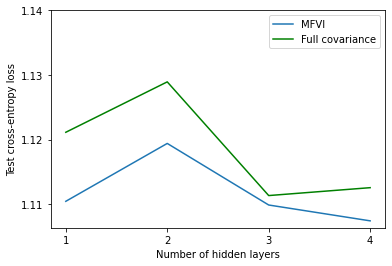

In [173]:
x=[1,2,3,4]
plt.plot(x,mean_r[0:4],label= "MFVI")
plt.plot(x,mean_r[4:8],'g',label= "Full covariance")
plt.xticks([1, 2, 3, 4])
plt.yticks([1.110,1.120, 1.130, 1.140])
plt.xlabel("Number of hidden layers")
plt.ylabel("Test cross-entropy loss")
plt.legend()
plt.savefig('figure.png')